In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from scipy.stats import norm

Running the whole program requires around 10 minutes.

## Problem 1

You are short 100 at-the-money call option contracts on the S&P 500 index expiring in one year
with a contract multiplier of 100. The current index level is 2600, the interest and dividend rates are zero.
Simulate the evolution of the index level at periods Δ𝑡 as a geometric Brownian motion with volatility 𝜎
(free parameter) and calculate the corresponding call value, delta, gamma and theta using a fixed 20%
implied volatility. Then simulate your actual cumulative P&L when periodically delta-hedging your
position (assuming you can trade the index as an asset) and compare it against the proxy formula on slide
11 for the following matrix of parameters:

In [2]:
def Delta(S, K, tau, r, sigma):
    '''delta of a call option'''
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    delta = norm.cdf(d1)
    
    return delta 

In [3]:
def Gamma(S, K, tau, r, sigma):
    '''gamma of a call option'''
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    pdf = 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * d1**2)
    gamma = pdf / (S * sigma * np.sqrt(tau))
    
    return gamma

In [4]:
def Theta(S, K, tau, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    
    pdf = 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * d1**2)
    theta = (-sigma * S * pdf) / (2 * np.sqrt(tau)) - r * K * np.exp(-r * tau) * norm.cdf(d2)
    
    return theta

In [5]:
def call(S, K, tau, r, sigma):
    '''price a call option by using the BS formula'''
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))    
    price = S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)
    
    return price

In [6]:
def GBM(S0, r, sig, T): 
    '''Construct a GBM path'''
    
    dt = 1/T
    dWt = np.random.normal(0, np.sqrt(dt), T)
    Wt = np.cumsum(dWt)
    t = np.linspace(0, 1, T+1)
    S = [S0]
    
    for i in range(1, T+1):
        St = S0 * np.exp((r - 0.5 * sig**2) * t[i-1] + sig * Wt[i-1])
        S.append(St)
    
    tau = 1-t # time to maturity
    return S, tau

In [7]:
def PnL_Calculator(sigma, T, S0=2600, K=2600, r=0, vol=0.2, N=10000, num_contract=100, multiplier=100):

    actual = [0] * N
    proxy = [0] * N
    
    d = [] # list of delta value
    g = [] # list of gamma value
    t = [] # list of theta value
    c = [] # list of call value
    
    for i in range(N): 
        S, tau = GBM(S0, r, sigma, T) # index level and time to maturity
        dt = 1/T # delta_t
        delta_old = Delta(S[0], K, tau[0], r, vol) # initial delta 
        
        for j in range(T):   
            gamma = Gamma(S[j], K, tau[j], r, vol) # calculate gamma 
            
            if N == 1:
                theta = Theta(S[j], K, tau[j], r, vol) # calculate theta
                opt = call(S[j], K, tau[j], r, vol) # calculate the value of call

                d.append(delta_old)
                g.append(gamma)
                t.append(theta)
                c.append(opt)
            
            # calculate the estimate of cumulative PnL
            proxy[i] += -0.5*gamma*S[j]**2*(((S[j+1]-S[j])/S[j])**2-(vol*np.sqrt(dt))**2)*num_contract*multiplier
            
            if j == 0:
                # proceeds of shorting 100 call and purchasing delta share of index
                actual[i] = (call(S[j], K, tau[j], r, vol) - delta_old*S[j]) * num_contract * multiplier
                continue
            
            delta_new = Delta(S[j], K, tau[j], r, vol) # new delta according to index movement
            actual[i] += -(delta_new - delta_old) * S[j] * num_contract * multiplier # delta-hedging every period
            delta_old = delta_new # update delta
        
        # proceeds in the last period: proceeds of selling all shares minus loss if the options are exercised
        actual[i] += (-max(S[-1]-K, 0) + delta_new * S[-1]) * num_contract * multiplier
        
    return np.mean(actual), np.mean(proxy), np.std(actual), np.std(proxy), d, g, t, c

In [8]:
print('The price of one call option is', call(2600, 2600, 1, 0, 0.2))
print('The initial delta is', Delta(2600, 2600, 1, 0, 0.2))
print('The initial gamma is', Gamma(2600, 2600, 1, 0, 0.2))
print('The initial theta is', Theta(2600, 2600, 1, 0, 0.2))

The price of one call option is 207.10475384055053
The initial delta is 0.539827837277029
The initial gamma is 0.0007633702836096381
The initial theta is -103.20766234402306


#### Value of call, delta, gamma, and theta on 252 trading days base on 1 simulation. $\sigma$ = 0.2

In [9]:
de, ga, th, ca = PnL_Calculator(0.2, 252, N=1)[4:]
time = list(range(1, 253))

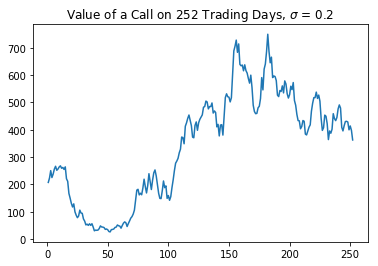

In [10]:
plt.plot(time, ca)
plt.title('Value of a Call on 252 Trading Days, $\sigma$ = 0.2');

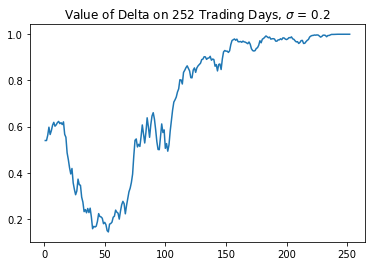

In [11]:
plt.plot(time, de)
plt.title('Value of Delta on 252 Trading Days, $\sigma$ = 0.2');

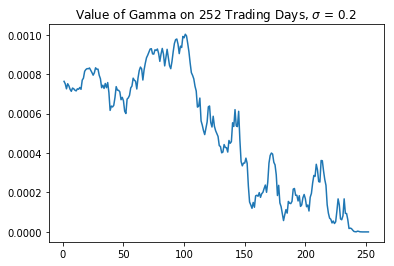

In [12]:
plt.plot(time, ga);
plt.title('Value of Gamma on 252 Trading Days, $\sigma$ = 0.2');

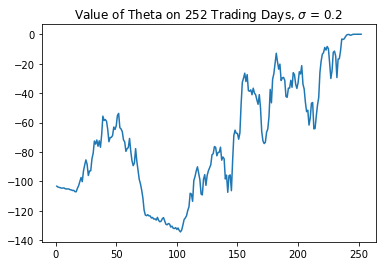

In [13]:
plt.plot(time, th);
plt.title('Value of Theta on 252 Trading Days, $\sigma$ = 0.2');

### Statistical Analysis (10000 Simulations)

In [14]:
T = [12, 52, 252]

pnl25 = [PnL_Calculator(0.25, t) for t in T]
pnl20 = [PnL_Calculator(0.20, t) for t in T]
pnl15 = [PnL_Calculator(0.15, t) for t in T]

In [15]:
act25mean = [x[0] for x in pnl25]
act20mean = [x[0] for x in pnl20]
act15mean = [x[0] for x in pnl15]

pro25mean = [x[1] for x in pnl25]
pro20mean = [x[1] for x in pnl20]
pro15mean = [x[1] for x in pnl15]

act25std = [x[2] for x in pnl25]
act20std = [x[2] for x in pnl20]
act15std = [x[2] for x in pnl15]

pro25std = [x[3] for x in pnl25]
pro20std = [x[3] for x in pnl20]
pro15std = [x[3] for x in pnl15]

In [16]:
df_act_mean = pd.DataFrame(np.array([act25mean, act20mean, act15mean]), \
                  index=['$\sigma$ = 25%', '$\sigma$ = 20%', '$\sigma$ = 15%'], \
                  columns=["Monthly (12 per year)", "Weekly (52 per year)", "Daily (252 per year)"])

df_pro_mean = pd.DataFrame(np.array([pro25mean, pro20mean, pro15mean]), \
                  index=['$\sigma$ = 25%', '$\sigma$ = 20%', '$\sigma$ = 15%'], \
                  columns=["Monthly (12 per year)", "Weekly (52 per year)", "Daily (252 per year)"])

df_act_std = pd.DataFrame(np.array([act25std, act20std, act15std]), \
                  index=['$\sigma$ = 25%', '$\sigma$ = 20%', '$\sigma$ = 15%'], \
                  columns=["Monthly (12 per year)", "Weekly (52 per year)", "Daily (252 per year)"])

df_pro_std = pd.DataFrame(np.array([pro25std, pro20std, pro15std]), \
                  index=['$\sigma$ = 25%', '$\sigma$ = 20%', '$\sigma$ = 15%'], \
                  columns=["Monthly (12 per year)", "Weekly (52 per year)", "Daily (252 per year)"])

### Mean

Here are the mean of the actual cumulative P&L

In [17]:
df_act_mean

,Monthly (12 per year),Weekly (52 per year),Daily (252 per year)
$\sigma$ = 25%,-520080.353183,-518799.665619,-512567.267693
$\sigma$ = 20%,-1290.761410,1518.299343,-1335.127699
$\sigma$ = 15%,518827.100762,515067.049554,517386.612339


Here are the mean of the proxy cumulative P&L calculated by the formula

In [18]:
df_pro_mean

,Monthly (12 per year),Weekly (52 per year),Daily (252 per year)
$\sigma$ = 25%,-529162.433388,-519902.743534,-512958.465516
$\sigma$ = 20%,-1955.521097,2133.968741,-1307.622332
$\sigma$ = 15%,512685.744617,513759.773268,516785.769155


We can see that the approximated PnL is close to the actual PnL.

### Standard Deviation

Here are the standard deviation of the actual cumulative P&L

In [19]:
df_act_std

,Monthly (12 per year),Weekly (52 per year),Daily (252 per year)
$\sigma$ = 25%,668891.794659,386051.244448,257082.930837
$\sigma$ = 20%,495543.653998,248268.189272,114298.307111
$\sigma$ = 15%,415645.497028,246652.808463,188837.475254


Here are the standard deviation of the proxy cumulative P&L calculated by the formula

In [20]:
df_pro_std

,Monthly (12 per year),Weekly (52 per year),Daily (252 per year)
$\sigma$ = 25%,675838.116928,382871.221494,254849.287584
$\sigma$ = 20%,481869.188827,244257.509850,113858.414333
$\sigma$ = 15%,371997.860241,233893.140446,185169.611171


## Problem 2

Use your knowledge of how the VIX is calculated to show that the VIX is not the price of an
investable asset. What about the square of the VIX?

The generalized formula for VIX is:

\begin{equation} \label{eq1}
\begin{split}
\left(\frac{VIX}{100}\right)^2 = \frac{2e^{rT}}{T}\sum_{i} \frac{\Delta K_i}{K_i^2}Q(K_i) - \frac{1}{T}\left(\frac{F}{K_0} -1\right)^2 \
\end{split}
\end{equation}


$VIX^2$  is adapted from the variance swap pricing formula, but only using liquid strikes. It’s an approximation of “future” implied volatility at 1M maturity. $VIX^2$ is a tradable assets as a linear combination of tradable assets.
But VIX is the square root of that. So it’s not linear in any tradable asset. It has to be replicated from a dynamic hedging/replication.

## Problem 3

On March 29, 2018 the S&P 500 index (SPX) is 2611.53 and the 12-month VIX is 21.28. The
implied volatility smile of SPX options expiring on March 15, 2019 is given as:
$$
\sigma^*(x) = \sqrt{a+b(\rho(x-m)+\sqrt{(x-m)^2+s^2}}
$$
where $𝑎 = 0.009, 𝑏 = 0.11, 𝜌 = −0.12, 𝑚 = 0.2, 𝑠 = 0.05, x=\ln{\frac{K}{F}}$
is log-moneyness and 𝐹 = 2625.10
is the forward price. The continuous interest rate is 2.09% p.a.

### (a) Volatility Surface

In [21]:
a = 0.009
b = 0.11 
rho = -0.12
m = 0.2
s = 0.05
F = 2625.1
S = 2611.53
r = 0.0209
t = 1 - 10/252 # An approximation of time to maturity (two weeks => 10 trading days)

In [22]:
sigma = []
frac = []
for K in range(500, 5001):
    sigx = np.sqrt(a + b * (rho * (np.log(K/F) - m) + np.sqrt((np.log(K/F) - m) ** 2 + s ** 2)))
    fracKS = K/S
    sigma.append(sigx)
    frac.append(fracKS)

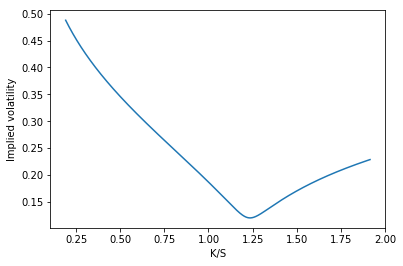

In [23]:
plt.plot(frac, sigma)
plt.ylabel('Implied volatility')
plt.xlabel('K/S')
plt.show();

### (b) Fair Variance Swap Strike

$$ VIX = \sqrt{\mathrm{E}[\int_{0}^{T} \sigma_{t}^{2} dt]}$$

In [24]:
def put(S, K, tau, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))    
    price = K * np.exp(-r * tau) * norm.cdf(-d2, 0.0, 1.0) - S * norm.cdf(-d1, 0.0, 1.0)
    
    return price

In [25]:
val = 0

# Calculate fair value of annualized variance
for K in range(500, 5001):
    vol = sigma[K-500]
    if K < F: 
        # Long all puts struck at K < F
        val += put(S, K, t, r, vol) / K**2 * 1
    else:
        # Long all calls struck at K > F
        val += call(S, K, t, r, vol) / K**2 * 1

In [26]:
K2_var = 2 * np.exp(r*t)/t * val
print('The fair variance swap strike is', K2_var)

The fair variance swap strike is 0.04360712741967372


In [27]:
cal_vix = 100 * np.sqrt(K2_var)
print('Our calculated VIX is', cal_vix)

Our calculated VIX is 20.882319655554006


It is very close to the 12-month VIX, but it is not exactly the same. This is becasue we use 4500 strikes for calculation. In practice, there may not be so many strikes available, and also the strikes in the market is very likely to be different from what we use here. 